### https://python.langchain.com/docs/how_to/document_loader_pdf/

* `python3.10 -m pip install pypdf langchain-unstructured "unstructured[pdf]" --user`
* `apt install tesseract-ocr`

In [1]:
from langchain_community.document_loaders import PyPDFLoader

file_path = 'data/input/llama2.pdf'
loader = PyPDFLoader( file_path )
pages = []
async for page in loader.alazy_load():
    pages.append( page )

In [2]:
print(f"{pages[0].metadata}\n")
print(pages[0].page_content)

{'source': 'data/input/llama2.pdf', 'page': 0}

Llama 2 : Open Foundation and Fine-Tuned Chat Models
Hugo Touvron∗Louis Martin†Kevin Stone†
Peter Albert Amjad Almahairi Yasmine Babaei Nikolay Bashlykov Soumya Batra
Prajjwal Bhargava Shruti Bhosale Dan Bikel Lukas Blecher Cristian Canton Ferrer Moya Chen
Guillem Cucurull David Esiobu Jude Fernandes Jeremy Fu Wenyin Fu Brian Fuller
Cynthia Gao Vedanuj Goswami Naman Goyal Anthony Hartshorn Saghar Hosseini Rui Hou
Hakan Inan Marcin Kardas Viktor Kerkez Madian Khabsa Isabel Kloumann Artem Korenev
Punit Singh Koura Marie-Anne Lachaux Thibaut Lavril Jenya Lee Diana Liskovich
Yinghai Lu Yuning Mao Xavier Martinet Todor Mihaylov Pushkar Mishra
Igor Molybog Yixin Nie Andrew Poulton Jeremy Reizenstein Rashi Rungta Kalyan Saladi
Alan Schelten Ruan Silva Eric Michael Smith Ranjan Subramanian Xiaoqing Ellen Tan Binh Tang
Ross Taylor Adina Williams Jian Xiang Kuan Puxin Xu Zheng Yan Iliyan Zarov Yuchen Zhang
Angela Fan Melanie Kambadur Sharan Narang 

In [3]:
def pull_ollama_model( modelStr ):
    """ Pull a named model from Ollama and store it wherever """
    print( f"About to save '{modelStr}'.\nThis will spew a lot of text on the first run..." )
    os.system( f"ollama pull {modelStr}" )

In [4]:
__import__('pysqlite3')
import sys, os, time
now = time.time
sys.modules['sqlite3'] = sys.modules.pop( 'pysqlite3' )

from langchain_chroma import Chroma
from langchain_ollama import OllamaEmbeddings
# from langchain_community import embeddings

pull_ollama_model( "nomic-embed-text" )

bgn = now()
local_embeddings = OllamaEmbeddings( model = "nomic-embed-text" )
vectorstore      = Chroma.from_documents( documents = pages, embedding = local_embeddings )
print( f"Built vector store in {now()-bgn} seconds!" )

About to save 'nomic-embed-text'.
This will spew a lot of text on the first run...


pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠼ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest 
pulling 970aa74c0a90... 100% ▕████████████████▏ 274 MB                         
pulling c71d239df917... 100% ▕████████████████▏  11 KB                         
pulling ce4a164fc046... 100% ▕████████████████▏   17 B                         
pulling 31df23ea7daa... 100% ▕████████████████▏  420 B                         
verifying sha256 digest pulling manifest 
pulling 970aa74c0a90... 100% ▕████████████████▏ 274 MB                         
pulling c71d239df917... 100% ▕████████████████▏  11 KB                         
pulling ce4a164fc046... 100% ▕████████████████▏   17 B                         
pulling 31df23ea7daa... 100% ▕████████████████▏  420 B                         
verifying sha256 digest 
writing manifest 
success 


Built vector store in 38.29773664474487 seconds!


### 2024-10-18: Langchain's API Key fails

In [5]:
# import getpass
# import os

# _UNSTRUCT_KEY_LOC = "secrets/Langchain_Unstructured.txt"

# with open( _UNSTRUCT_KEY_LOC, 'r' ) as f:
#     os.environ["UNSTRUCTURED_API_KEY"] = str( f.read() ).strip()
    

In [6]:
# from langchain_unstructured import UnstructuredLoader

# loader = UnstructuredLoader(
#     file_path = file_path,
#     strategy  = "hi_res",
#     partition_via_api = True,
#     coordinates = True,
# )
# docs = []
# for doc in loader.lazy_load():
#     docs.append( doc )

### https://python.langchain.com/docs/how_to/document_loader_pdf/#local-parsing

In [7]:
from langchain_unstructured import UnstructuredLoader

loader_local = UnstructuredLoader(
    file_path = file_path,
    strategy  = "fast", #"hi_res",
)
docs_local = []
for doc in loader_local.lazy_load():
    docs_local.append( doc )

INFO: pikepdf C++ to Python logger bridge initialized


In [8]:
len( docs_local )

2664

In [9]:
from langchain_ollama import ChatOllama

pull_ollama_model( "llava" )

llm = ChatOllama(
    model="llava",
)

About to save 'llava'.
This will spew a lot of text on the first run...


pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠼ pulling manifest 
pulling 170370233dd5... 100% ▕████████████████▏ 4.1 GB                         
pulling 72d6f08a42f6... 100% ▕████████████████▏ 624 MB                         
pulling 43070e2d4e53... 100% ▕████████████████▏  11 KB                         
pulling c43332387573... 100% ▕████████████████▏   67 B                         
pulling ed11eda7790d... 100% ▕████████████████▏   30 B                         
pulling 7c658f9561e5... 100% ▕████████████████▏  564 B                         
verifying sha256 digest 
writing manifest 
success 


In [11]:
import base64
import io

import fitz
from PIL import Image


def pdf_page_to_base64(pdf_path: str, page_number: int):
    pdf_document = fitz.open(pdf_path)
    page = pdf_document.load_page(page_number - 1)  # input is one-indexed
    pix = page.get_pixmap()
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    buffer = io.BytesIO()
    img.save(buffer, format="PNG")

    return base64.b64encode(buffer.getvalue()).decode("utf-8")

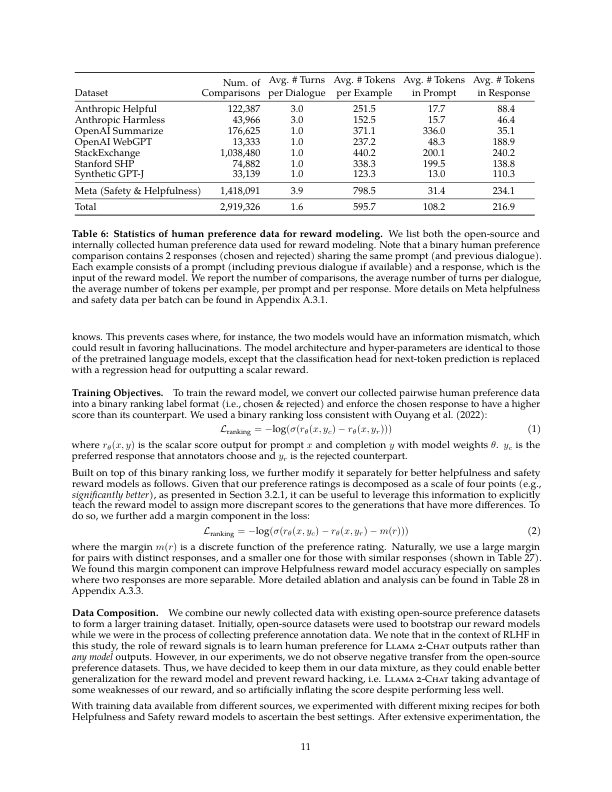

In [12]:
from IPython.display import Image as IPImage
from IPython.display import display

base64_image = pdf_page_to_base64(file_path, 11)
display( IPImage( data = base64.b64decode( base64_image ) ) )

In [14]:
from langchain_core.messages import HumanMessage

query = "What can be said about the data composition?"

message = HumanMessage(
    content=[
        {"type": "text", "text": query},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
        },
    ],
)
bgn = now()
response = llm.invoke( [message] )
print( f"LLM query took {now()-bgn} seconds to process!" )
print( response.content )

INFO: HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


LLM query took 19.70475482940674 seconds to process!
 The image displays a table of data. It appears to be from a scientific or technical document, given the structured format and specific column headings such as "Sites," "Data," "Average," and "Standard Deviation." The table includes multiple rows with columns for each piece of data related to a particular measurement.

The "Data" column contains numerical values that likely represent some form of measurement or observation, although the context of these measurements is not clear from the image alone. The "Average" column provides an arithmetic mean for the corresponding data sets, and the "Standard Deviation" column shows the amount by which the values in each row deviate from the average value.

The footnote at the bottom indicates that a certain amount of data is missing, as it mentions "9 out of 12..." This suggests that there are some entries that are not present in the table, possibly because they were not recorded or were deeme